## Import Libraries

In [93]:
import os
import h5py
import numpy as np
import pandas as pd
from pandas import DataFrame
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

## Loading Data

In [94]:
# Load data
def load_part_array (sample_dir_path, unit_num, win_len, stride, part_num):
    filename =  'Unit%s_win%s_str%s_part%s.npz' %(str(int(unit_num)), win_len, stride, part_num)
    filepath =  os.path.join(sample_dir_path, filename)
    loaded = np.load(filepath)
    return loaded['sample'], loaded['label']

def load_part_array_merge (npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

def load_array (sample_dir_path, unit_num, win_len, stride):
    filename =  'Unit%s_win%s_str%s_smp10.npz' %(str(int(unit_num)), win_len, stride)
    filepath =  os.path.join(sample_dir_path, filename)
    loaded = np.load(filepath)

    return loaded['sample'].transpose(2, 0, 1), loaded['label']

### Choosing Specific Unitis for Training and Testing

In [95]:
def release_list(a):
   del a[:]
   del a

units_index_train = [16.0, 18.0, 20.0]
units_index_test = [11.0, 14.0, 15.0]

sample_dir_path ='Samples_whole'
sub=10

train_units_samples_lst =[]
train_units_labels_lst = []

for index in units_index_train:
        print("Load data index: ", index)
        sample_array, label_array = load_array (sample_dir_path, index, 50, 1)
        #sample_array, label_array = shuffle_array(sample_array, label_array)
        print("sample_array.shape", sample_array.shape)
        print("label_array.shape", label_array.shape)
        sample_array = sample_array[::sub]
        label_array = label_array[::sub]
        print("sub sample_array.shape", sample_array.shape)
        print("sub label_array.shape", label_array.shape)
        train_units_samples_lst.append(sample_array)
        train_units_labels_lst.append(label_array)
        
sample_array = np.concatenate(train_units_samples_lst)
label_array = np.concatenate(train_units_labels_lst)
print ("samples are aggregated")

release_list(train_units_samples_lst)
release_list(train_units_labels_lst)
train_units_samples_lst =[]
train_units_labels_lst = []
print("Memory released")

    #sample_array, label_array = shuffle_array(sample_array, label_array)
print("samples are shuffled")
print("sample_array.shape", sample_array.shape)
print("label_array.shape", label_array.shape)

print ("train sample dtype", sample_array.dtype)
print("train label dtype", label_array.dtype)

Load data index:  16.0
sample_array.shape (76480, 50, 20)
label_array.shape (76480,)
sub sample_array.shape (7648, 50, 20)
sub label_array.shape (7648,)
Load data index:  18.0
sample_array.shape (89023, 50, 20)
label_array.shape (89023,)
sub sample_array.shape (8903, 50, 20)
sub label_array.shape (8903,)
Load data index:  20.0
sample_array.shape (76767, 50, 20)
label_array.shape (76767,)
sub sample_array.shape (7677, 50, 20)
sub label_array.shape (7677,)
samples are aggregated
Memory released
samples are shuffled
sample_array.shape (24228, 50, 20)
label_array.shape (24228,)
train sample dtype float32
train label dtype float32


### Convoloutional Nueral Network

In [96]:
model = tf.keras.Sequential(name="model_conv1D")
model.add(tf.keras.layers.Input(shape=(sample_array.shape[1],sample_array.shape[2]), name="input"))
model.add(tf.keras.layers.Conv1D(filters=9, kernel_size=3, strides=1, padding='same', activation='relu', name="Conv1D_1"))
model.add(tf.keras.layers.Conv1D(filters=9, kernel_size=3, strides=1, padding='same', activation='relu', name="Conv1D_2"))
  
model.add(tf.keras.layers.Conv1D(filters=9, kernel_size=3, strides=1, padding='same', activation='relu', name="Conv1D_3"))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=3, strides=1, padding='same', activation='relu', name="Conv1D_4"))
  
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu', name="Dense_1"))
model.add(tf.keras.layers.Dense(1, activation='linear', name="Dense_2"))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
print(model.summary())

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 50, 9)             549       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 50, 9)             252       
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 50, 9)             252       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 50, 1)             28        
_________________________________________________________________
flatten_13 (Flatten)         (None, 50)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
Dense_2 (Dense)              (None, 1)                

In [97]:
history = model.fit(
    sample_array,
    label_array,
    validation_split=0.1,
    epochs=250,
    batch_size=512,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/250
43/43 [==============================] - 1s 6ms/step - loss: 1197.1906 - mean_squared_error: 1197.1906 - val_loss: 1138.8770 - val_mean_squared_error: 1138.8770
Epoch 2/250
43/43 [==============================] - 0s 4ms/step - loss: 420.6388 - mean_squared_error: 420.6388 - val_loss: 710.7925 - val_mean_squared_error: 710.7925
Epoch 3/250
43/43 [==============================] - 0s 4ms/step - loss: 368.2999 - mean_squared_error: 368.2999 - val_loss: 696.2688 - val_mean_squared_error: 696.2688
Epoch 4/250
43/43 [==============================] - 0s 4ms/step - loss: 353.0310 - mean_squared_error: 353.0310 - val_loss: 669.2526 - val_mean_squared_error: 669.2526
Epoch 5/250
43/43 [==============================] - 0s 4ms/step - loss: 335.9728 - mean_squared_error: 335.9728 - val_loss: 688.7085 - val_mean_squared_error: 688.7085
Epoch 6/250
43/43 [==============================] - 0s 4ms/step - loss: 302.3578 - mean_squared_error: 302.3578 - val_loss: 513.5201 - val_mean_square

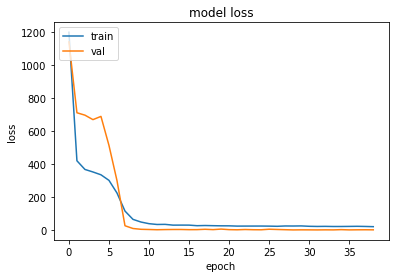

5.995938834012628


In [98]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


from math import sqrt
from sklearn.metrics import mean_squared_error

output_lst = []
truth_lst = []   

for index in units_index_test:
        sample_array, label_array = load_array(sample_dir_path, index, 50, 1)
        sample_array = sample_array[::sub]
        label_array = label_array[::sub]

        y_pred_test = model.predict(sample_array)
        output_lst.append(y_pred_test)
        truth_lst.append(label_array)

output_array = np.concatenate(output_lst)[:, 0]
trytg_array = np.concatenate(truth_lst)

RMSE = sqrt(mean_squared_error(output_array, trytg_array))
print(RMSE)


### Saving Model

In [99]:
model.save('WindowingCNN.h5')